In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', False)

In [3]:
df = pd.read_csv('/content/AAPL.csv')

In [4]:
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [5]:
df.drop(columns=['Unnamed: 0', 'symbol'], axis=1, inplace=True) #removing useless 'Unnamed: 0' column

In [6]:
df.isnull().sum() #checking any null values

date           0
close          0
high           0
low            0
open           0
volume         0
adjClose       0
adjHigh        0
adjLow         0
adjOpen        0
adjVolume      0
divCash        0
splitFactor    0
dtype: int64

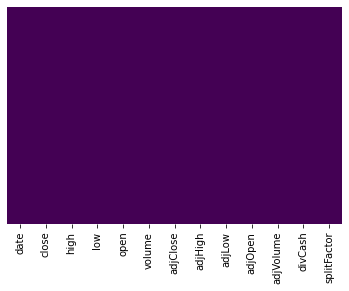

In [7]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [8]:
#In this project i will be doing stock predictions based on 'close' column only
df_close = df.reset_index()['close']

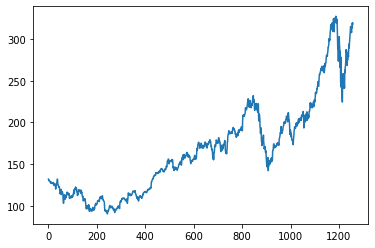

In [9]:
plt.plot(df_close)

In [10]:
#feature scaling for LSTM

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(df_close).reshape(df_close.shape[0], 1))

In [11]:
#splitting data into train and test split
#I'm not using train_test_split or cross_validation because here, the sequence matters

train_size = int(len(scaled_data)*0.7)
test_size = int(len(scaled_data)-train_size)

X_train, X_test = scaled_data[:train_size,:], scaled_data[train_size:,:]

In [12]:
#prepare data for LSTM training

def prepare_dataset(dataset, timesteps=1):
    
    X_data = []
    y_data = []
    
    for i in range(len(dataset)-timesteps-1):
        X_data.append(dataset[i:i+timesteps, 0])
        y_data.append(dataset[i+timesteps, 0])
        
    return np.array(X_data), np.array(y_data)

In [13]:
x_train, y_train = prepare_dataset(X_train, timesteps=100)
x_test, y_test = prepare_dataset(X_test, timesteps=100)

In [14]:
#converting to required shape for LSTM 

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [15]:
#model creation
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

In [ ]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [16]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(units=100))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [18]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=1, validation_data=(x_test, y_test))

Epoch 1/100
13/13 [==============================] - 4s 278ms/step - loss: 0.0174 - val_loss: 0.0536
Epoch 2/100
13/13 [==============================] - 3s 217ms/step - loss: 0.0026 - val_loss: 0.0057
Epoch 3/100
13/13 [==============================] - 3s 217ms/step - loss: 7.9453e-04 - val_loss: 0.0028
Epoch 4/100
13/13 [==============================] - 3s 217ms/step - loss: 4.9449e-04 - val_loss: 0.0025
Epoch 5/100
13/13 [==============================] - 3s 213ms/step - loss: 4.5128e-04 - val_loss: 0.0029
Epoch 6/100
13/13 [==============================] - 3s 214ms/step - loss: 4.2644e-04 - val_loss: 0.0034
Epoch 7/100
13/13 [==============================] - 3s 217ms/step - loss: 4.2095e-04 - val_loss: 0.0028
Epoch 8/100
13/13 [==============================] - 3s 217ms/step - loss: 4.0901e-04 - val_loss: 0.0025
Epoch 9/100
13/13 [==============================] - 3s 214ms/step - loss: 4.0817e-04 - val_loss: 0.0032
Epoch 10/100
13/13 [==============================] - 3s 214ms/

In [19]:
#prediction
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

#transforming back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [20]:
#calculating RMSE performance metrics on train data

import math
from sklearn.metrics import mean_squared_error

In [21]:
print(math.sqrt(mean_squared_error(y_train, train_predict)))

148.312714066172


In [22]:
#calculating RMSE performance metrics on test data

print(math.sqrt(mean_squared_error(y_test, test_predict)))

244.96997011428508


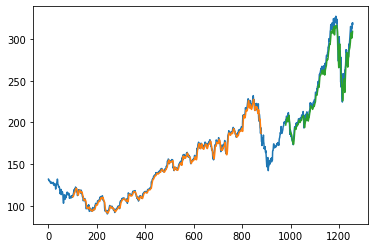

In [26]:
#Plotting results

#shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

#shift test predictions for plotting
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(scaled_data)-1, :] = test_predict

#plot baseline and predictions
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [33]:
#Predicting for next 50 days
#for prediction we need 100 days before data in order to predict further

x_input = X_test[278:].reshape(1,-1)
x_new_data = list(x_input)
x_new_data = x_new_data[0].tolist()

In [34]:
lst_output = []
n_steps = 100
i = 0

while(i < 50):
    if(len(x_new_data)>100):
#         print(x_new_data)
        x_input = np.array(x_new_data[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
#         print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        x_new_data.extend(yhat[0].tolist())
        x_new_data = x_new_data[1:]
#         print(x_new_data)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
        x_new_data.extend(yhat[0].tolist())
#         print(len(x_new_data))
        lst_output.extend(yhat.tolist())
        i = i+1
    

print(lst_output)

1 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.90095415 0.927932

In [35]:
#Plotting predicted data

old_days = np.arange(1,101)
pred_days = np.arange(101,151)

In [36]:
len(scaled_data)

1258

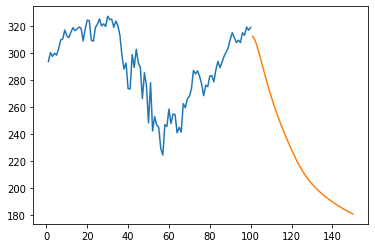

In [38]:
plt.plot(old_days, scaler.inverse_transform(scaled_data[1158:]))
plt.plot(pred_days, scaler.inverse_transform(lst_output))

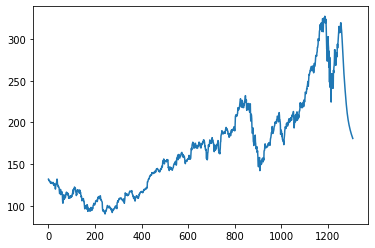

In [39]:
#combined plot

final_df = scaled_data.tolist()
final_df.extend(lst_output)
final_df = scaler.inverse_transform(final_df).tolist()
plt.plot(final_df)